In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal as normd
%matplotlib inline

# Particle resampling

The goal of this notebook is to investigate how a discrete velocity distribution of N velocities can be resampled into M others. The idea is to use the Kernel Density Estimation method

## First generate the gridded distribution from the discrete one

We first draw 1000 2D velocities from a Maxwellian distribution with $\sigma = 0.2$ and represent the discrete distribution with a scatter plot

In [68]:
part_nbr = 100000

In [155]:
d1,d2 = 0.1*normd(size=(2,part_nbr)), 0.05*normd(size=(2,part_nbr))+0.2

In [156]:
v = np.concatenate((d1,d2), axis=1)

In [157]:
def scatterv(v):
    f,a = plt.subplots(figsize=(7,7))
    a.axvline(ls="--", color="k")
    a.axhline(ls="--", color="k")
    a.scatter(v[0,:], v[1,:], s=1)
    a.set_xlabel(r"$V_x$")
    a.set_ylabel(r"$V_y$")
    a.set_title("Discrete distribution of N={} velocities".format(v.shape[1]))

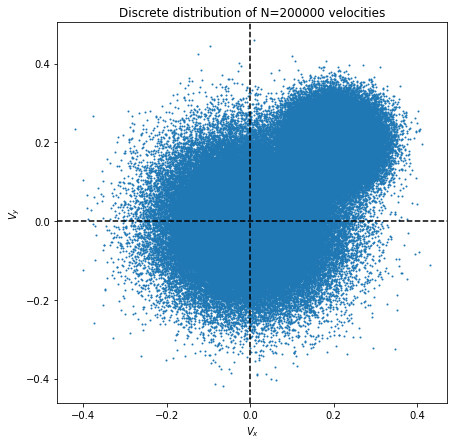

In [158]:
scatterv(v)

In [159]:
def statp(v):
    print("mean : ({:6.5f},{:6.5f}), std : ({:6.5f},{:6.5f})".format(v[0,:].mean(),
                                                 v[1,:].mean(),
                                                 v[0,:].std(),
                                                 v[1,:].std()))

In [160]:
statp(v)

mean : (0.09995,0.09973), std : (0.12748,0.12762)


Now let's create the "kde kernel" using the scipy gaussian_kde method. The we build the axis coordinates we want to evaluate the kde upon and plot the result

In [161]:
import scipy.stats as stats

In [162]:
kde = stats.gaussian_kde(v)
nvx,nvy = 100,100
# Regular grid to evaluate kde upon
v1 = np.linspace(-0.6,0.6,nvx)
v2 = np.linspace(-0.6,0.6,nvy)
vv1,vv2 = np.meshgrid(v1, v2, indexing='ij')

grid_coords = np.append(vv1.reshape(-1,1),vv2.reshape(-1,1),axis=1)

z = kde(grid_coords.T)
z = z.reshape(nvx,nvy)


/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


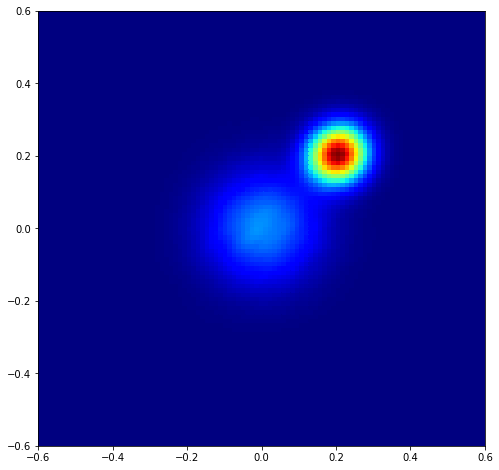

In [163]:
plt.figure(figsize=(8,8))
plt.pcolormesh(vv1,vv2,z, cmap="jet")

## Then draw M random velocities from t

In [164]:
# we simply resample the kde 
part_nbr2 = 5000
new_vel = kde.resample(part_nbr2)

In [165]:
# and obtain our new velocities
new_vel.shape 

(2, 5000)

Let us now plot our new velocities and print their statistical properties, they should be similar to the original distirbution

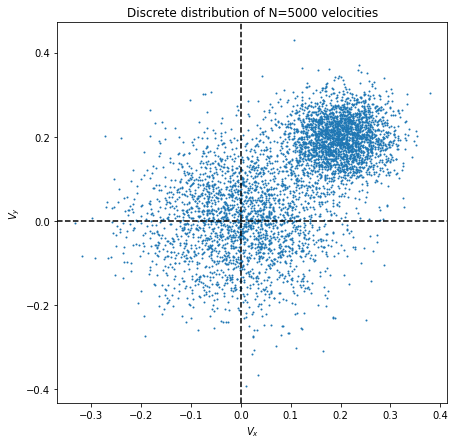

In [166]:
scatterv(new_vel)

In [167]:
statp(new_vel)

mean : (0.10134,0.10100), std : (0.12670,0.12741)


## The case of a spatially variable distribution of velocities $f(r,v)$

One question is to know the spatial scale over which to select particles to build a gridded distribution when particles are also distributed in space.

The "cell" from the field mesh seems irrelevant since it is not related to any local plasma behavior. Furthermore a cell typically embeds 100 particles, which is quite rough statistically speaking...

One idea could be to build distributions at regularly spaced locations taking all particles around that location until a certain number that is deemed sufficient is reached. That could probably easily be done by drawing a tree over the whole domain, recursively splitting space in smaller regions until there is only 1 particle in each subdivision. Browsing the tree could then provide a list of all M particles neighboring the location at which a distribution is to be built.

However that only consider a statistical argument and the region over which the distribution is made could be arbitrarily large compared to distances that could be considered relevant from a physical standpoint.

For instance, one could define a "local" physical length scale that would be the smallest one to define a distribution centered at location $r$. That distance would be such that it encloses all particles around $r$ with a Larmor radius enabling them to access $r$.

etc.

Ok let's draw particle position in a given spatial domain, then pick one particle and build a tree to find the neighbor in a certain distance from it

In [168]:
domain = (10,15)

In [169]:
# generate positions
x = np.random.rand(part_nbr)*domain[0]
y = np.random.rand(part_nbr)*domain[1]

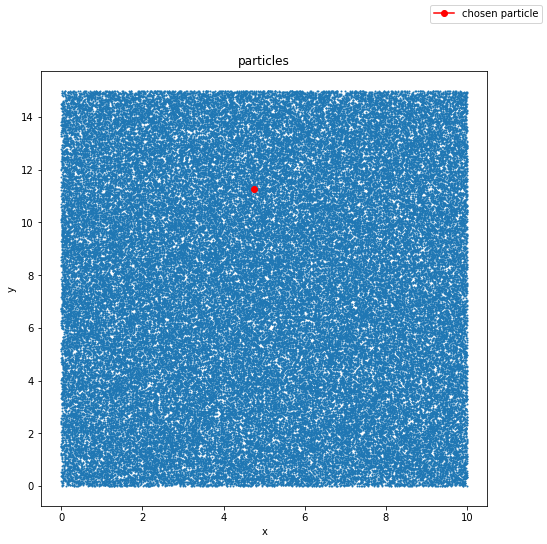

In [170]:
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(x, y, s=1)
ax.set_title("particles")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.plot(x[25],y[25], marker='o', color='r', label="chosen particle")
fig.legend()

In [171]:
from scipy.spatial import KDTree

In [172]:
xy = np.asarray([x,y])
t = KDTree(xy.T, leafsize=1)

In [173]:
xy[:,25]

array([ 4.75794867, 11.2885607 ])

In [174]:
indexes = t.query_ball_point(xy[:,25],1)

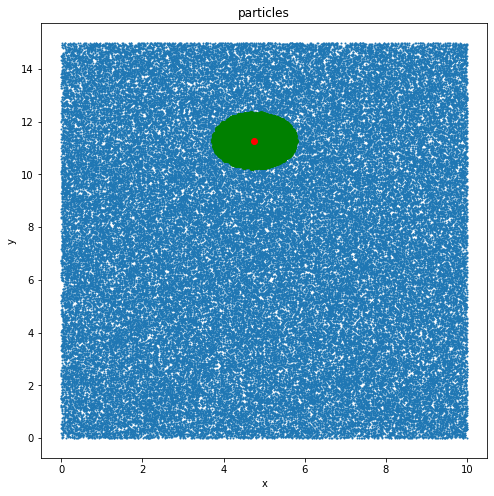

In [175]:
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(x, y, s=1)
ax.set_title("particles")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.plot(x[25],y[25], marker='o', color='r')
ax.scatter(x[indexes],y[indexes], marker='o', color='g')

In [176]:
# build a tree
# compute local larmor radius?